In [1]:
# working dir
import os
import sys

cwd = os.getcwd()
root_dir = os.path.dirname(os.path.dirname(cwd))
sys.path.append(root_dir)

print(root_dir)

c:\Users\david\Desktop\Main\03_Uni\WWI21DSA\02_Vorlesungen\06_Projektrealisierung\Projektrealisierung


In [2]:
# Imports and settings
import pandas as pd
import random

random.seed(42)

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)

In [3]:
import pandas as pd
from IPython.display import display, HTML

# Display Dataframe (with scrollbars)
def ddf(df, max_height=500, max_width=1500):
    """
    Display a pandas DataFrame with horizontal and vertical scrollbars in a Jupyter notebook.
    
    Parameters:
    df (pd.DataFrame): The DataFrame to display.
    max_height (int): The maximum height of the scrollable area in pixels.
    max_width (int): The maximum width of the scrollable area in pixels.
    """
    style = f"""
    <style>
    .scrollable-dataframe {{
        max-height: {max_height}px;
        max-width: {max_width}px;
        overflow: auto;
        display: inline-block;
        position: relative;
    }}
    .scrollable-dataframe thead th {{
        position: sticky;
        top: 0;
        background-color: white;
        z-index: 1;
    }}
    </style>
    """
    html = style + df.to_html(classes='scrollable-dataframe')
    display(HTML(html))


In [4]:
main = pd.concat([
    pd.read_csv("../../src/data/ABCD_tripfiles_preprocessed.csv"),
    # pd.read_csv("../../src/data/MNOP_tripfiles_preprocessed.csv"),
    pd.read_csv("../../src/data/ZYXW_tripfiles_preprocessed.csv"),
])

meta_cols = ['flight_id', 'id', 'creation_time', 'airline_code', 'flight_date', 'action_name',]
action_cols = ['departureAirport', 'departureTime', 'arrivalAirport', 'arrivalTime', 'aircraftRegistration', 'aircraftSubtype', 'aircraftVersion',]

main = main.loc[
    main["action_name"] == "CalculateWeightAndTrimAction",
    meta_cols + action_cols
]

C:\Users\david\AppData\Local\Temp\ipykernel_332\3388144568.py:2: DtypeWarning: Columns (14,15,16,17,18,19,20,21,22,23,24,26,27,28) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv("../../src/data/ABCD_tripfiles_preprocessed.csv"),
C:\Users\david\AppData\Local\Temp\ipykernel_332\3388144568.py:4: DtypeWarning: Columns (26,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv("../../src/data/ZYXW_tripfiles_preprocessed.csv"),


In [5]:
import warnings
warnings.filterwarnings('ignore') # disable future deprecation warning of .fillna() method

def fill_na_within_group(group):
    group[action_cols] = group[action_cols].fillna(method='bfill')
    group[action_cols] = group[action_cols].fillna(method='ffill')
    return group

main = main.groupby("flight_id").apply(fill_na_within_group).reset_index(drop=True) # replaces NaN values with the values from the previous or next row within the same flight
main.dropna(inplace=True) # drops 203828 rows - these are likely flights without an ASMMsgProcessor action

warnings.filterwarnings('default')

In [6]:
def correct_year(date_str):
    date_part, time_part = date_str.split('T')
    year, month, day = date_part.split('-')
    hours, minutes, seconds = time_part.split(':')

    # Correct year
    if len(year) != 4:
        year = year[1:]
    
    # Correct the minutes
    if len(minutes) > 2:
        minutes = minutes[:2]

    # Correct the seconds
    if len(seconds) > 6:
        seconds = "00.000Z"
    
    date_part = f"{year}-{month}-{day}"
    time_part = f"{hours}:{minutes}:{seconds}"
    date_str = f"{date_part}T{time_part}"
    
    return date_str

# Fix year in departureTime and arrivalTime
main["departureTime"] = main["departureTime"].apply(lambda x: correct_year(str(x)))
main["arrivalTime"] = main["arrivalTime"].apply(lambda x: correct_year(str(x)))


main["creation_time"] = pd.to_datetime(main["creation_time"])
main["departureTime"] = pd.to_datetime(main["departureTime"], format="%Y-%m-%dT%H:%M:%S.%fZ")
main["arrivalTime"] = pd.to_datetime(main["arrivalTime"], format="%Y-%m-%dT%H:%M:%S.%fZ")

main["minutes_till_dep"] = (main["departureTime"] - main["creation_time"]).dt.total_seconds() / 60

In [7]:
cwata = pd.concat([
    pd.read_csv("../../src/data/extracted/abcd_CalculateWeightAndTrimAction.csv"), 
    # pd.read_csv("../../src/data/extracted/mnop_CalculateWeightAndTrimAction.csv"), 
    pd.read_csv("../../src/data/extracted/zyxw_CalculateWeightAndTrimAction.csv")
    ])

cwata = cwata[[
    'id', 'START_WI_weight', 
    'DO_WI_weight', 'PAX_WI_weight', 'TOTAL_DEADLOAD_WI_weight', 'TOTAL_LOAD_WI',
    'TOTAL_TRAFFIC_LOAD', 'AZFW', 'ATOW', 'ALAW', 'ATXW', 
    'ALLOWED_TOW', 'ALLOWED_ZFW', 'ALLOWED_LAW', 'ALLOWED_TXW', 'UNDERLOAD',
    'ESTIMATED_TRAFFIC_LOAD', 'ESTIMATED_ZFW', 'DELTA_ZFW'
    ]]

In [8]:
df = pd.merge(cwata, main, on="id", how="left")

df.dropna(inplace=True)
df.sort_values(by=["flight_id", "creation_time", "id"], inplace=True, ascending=True)

In [9]:
max_value = 150_000

removed_rows = 0
for col in ['START_WI_weight', 'DO_WI_weight', 'PAX_WI_weight',
       'TOTAL_DEADLOAD_WI_weight', 'TOTAL_LOAD_WI', 'TOTAL_TRAFFIC_LOAD',
       'AZFW', 'ATOW', 'ALAW', 'ATXW', 'ALLOWED_TOW', 'ALLOWED_ZFW',
       'ALLOWED_LAW', 'ALLOWED_TXW', 'UNDERLOAD', 'ESTIMATED_TRAFFIC_LOAD',
       'ESTIMATED_ZFW', 'DELTA_ZFW']:
    
    ldf = len(df)
    df = df[df[col] <= max_value]
    removed_rows += ldf - len(df)

print("removed rows:", removed_rows)

removed rows: 462


In [10]:
azfw_all = df.groupby('flight_id')['ATOW'].last()
azfw_all = azfw_all.to_dict()

df["target_ATOW"] = df["flight_id"].map(azfw_all)

In [11]:
special_cols = ['flight_id', 'creation_time', 'id', 'action_name', "departureTime", "arrivalTime"]
cat_cols = ["airline_code", "departureAirport", "arrivalAirport", "aircraftRegistration", "aircraftSubtype", "aircraftVersion"]
target_col = "target_ATOW"
num_cols = list(set(df.columns) - set(cat_cols) - set(special_cols) - {target_col})

In [12]:
# Transform data (dft = dataframe transformed)
from sklearn.preprocessing import StandardScaler


dft = pd.get_dummies(df, columns=cat_cols, drop_first=True)

scaler = StandardScaler()
dft[num_cols] = scaler.fit_transform(dft[num_cols])

target_scaler = StandardScaler()
dft[target_col] = target_scaler.fit_transform(dft[[target_col]])

In [13]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split


# Assume 'dft' is your DataFrame and 'flight_id' is the column name for flight IDs
flight_ids = dft['flight_id'].unique()

# Split flight IDs into train, val, and test
train_ids, test_ids = train_test_split(flight_ids, test_size=0.3, random_state=42)
val_ids, test_ids = train_test_split(test_ids, test_size=1/3, random_state=42)

# Function to create datasets based on flight IDs
def create_dataset(dft, ids):
    df_subset = dft[dft['flight_id'].isin(ids)]
    X = df_subset.drop(columns=[target_col] + special_cols)
    y = df_subset[target_col]
    X = X.astype(float)
    X_tensor = torch.tensor(X.values, dtype=torch.float32)
    y_tensor = torch.tensor(y.values, dtype=torch.float32)
    return TensorDataset(X_tensor, y_tensor)

train_dataset = create_dataset(dft, train_ids)
val_dataset = create_dataset(dft, val_ids)
test_dataset = create_dataset(dft, test_ids)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)


In [14]:
# print(
#     f"X shape: {X_tensor.shape}",
#     f"y shape: {y_tensor.shape}",
#     f"Feature variance:\n{X.var()}",
#     f"Target variance:\n{y.var()}",
#     sep="\n"
# )

# #> Looking good

In [47]:
import torch.nn as nn

class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1) 

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        x = x.squeeze()
        return x
    
class Regression(nn.Module):
    def __init__(self, input_size):
        super(Regression, self).__init__()
        self.fc = nn.Linear(input_size, 1) 

    def forward(self, x):
        x = self.fc(x)
        x = x.squeeze()
        return x

input_size = train_dataset.tensors[0].shape[1]
model = SimpleNN(input_size)
# model = Regression(input_size)

In [50]:
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

model.apply(weights_init)


SimpleNN(
  (fc1): Linear(in_features=439, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)

In [51]:
import torch.optim as optim
from tqdm import tqdm
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau


criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True, threshold=1e-4)

# Early Stopping Parameters
early_stopping_patience = 10
best_loss = float('inf')
patience_counter = 0

# Training Loop 
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    losses = []
    train_loader_tqdm = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch')
    for inputs, labels in train_loader_tqdm:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        if torch.isnan(loss) or torch.isinf(loss):
            print("NaN or Inf loss detected")
            break

        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        train_loader_tqdm.set_postfix(loss=np.mean(losses))
    
    epoch_loss = np.mean(losses)
    print(f"Epoch {epoch+1}, Training Loss: {epoch_loss}")

    # Validation phase
    model.eval()
    val_losses = []
    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)
            val_losses.append(val_loss.item())

    val_loss_mean = np.mean(val_losses)
    print(f"Epoch {epoch+1}, Validation Loss: {val_loss_mean}")

    # Step the scheduler
    scheduler.step(val_loss_mean)
    print(f"Learning rate: {scheduler.get_last_lr()}")

    # Early Stopping Check
    if val_loss_mean < best_loss:
        best_loss = val_loss_mean
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= early_stopping_patience:
        print(f"Early stopping at epoch {epoch+1}")
        break



Epoch 1/100: 100%|██████████| 573/573 [00:08<00:00, 68.34batch/s, loss=6.66]


Epoch 1, Training Loss: 6.6596502249086855
Epoch 1, Validation Loss: 0.02490659770311466
Learning rate: [0.1]


Epoch 2/100: 100%|██████████| 573/573 [00:08<00:00, 66.55batch/s, loss=0.0126]


Epoch 2, Training Loss: 0.012633896194703969
Epoch 2, Validation Loss: 0.01462406502787978
Learning rate: [0.1]


Epoch 3/100: 100%|██████████| 573/573 [00:09<00:00, 61.95batch/s, loss=0.011] 


Epoch 3, Training Loss: 0.0110445081725242
Epoch 3, Validation Loss: 0.011414067778304466
Learning rate: [0.1]


Epoch 4/100: 100%|██████████| 573/573 [00:09<00:00, 62.11batch/s, loss=0.00736]


Epoch 4, Training Loss: 0.007355137771429465
Epoch 4, Validation Loss: 0.012692088263043215
Learning rate: [0.1]


Epoch 5/100: 100%|██████████| 573/573 [00:09<00:00, 62.69batch/s, loss=0.00698]


Epoch 5, Training Loss: 0.006984336267145803
Epoch 5, Validation Loss: 0.010828246898862194
Learning rate: [0.1]


Epoch 6/100: 100%|██████████| 573/573 [00:09<00:00, 61.58batch/s, loss=0.00646]


Epoch 6, Training Loss: 0.006456488048589511
Epoch 6, Validation Loss: 0.012024094374889197
Learning rate: [0.1]


Epoch 7/100: 100%|██████████| 573/573 [00:09<00:00, 62.25batch/s, loss=0.00604]


Epoch 7, Training Loss: 0.006038582078010546
Epoch 7, Validation Loss: 0.016980929676742283
Learning rate: [0.1]


Epoch 8/100: 100%|██████████| 573/573 [00:09<00:00, 61.20batch/s, loss=0.00568]


Epoch 8, Training Loss: 0.005680522096813063
Epoch 8, Validation Loss: 0.012671454800443759
Learning rate: [0.1]


Epoch 9/100: 100%|██████████| 573/573 [00:09<00:00, 59.32batch/s, loss=0.00613]


Epoch 9, Training Loss: 0.006128286618176998
Epoch 9, Validation Loss: 0.013438690671687199
Learning rate: [0.1]


Epoch 10/100: 100%|██████████| 573/573 [00:09<00:00, 60.71batch/s, loss=0.00641]


Epoch 10, Training Loss: 0.0064140542068585335
Epoch 10, Validation Loss: 0.015457446343606096
Learning rate: [0.1]


Epoch 11/100: 100%|██████████| 573/573 [00:09<00:00, 58.93batch/s, loss=0.011]  


Epoch 11, Training Loss: 0.010970060748534105
Epoch 11, Validation Loss: 0.014205328592966615
Learning rate: [0.010000000000000002]


Epoch 12/100: 100%|██████████| 573/573 [00:09<00:00, 59.75batch/s, loss=0.00256]


Epoch 12, Training Loss: 0.0025636449124644563
Epoch 12, Validation Loss: 0.01111656322106604
Learning rate: [0.010000000000000002]


Epoch 13/100: 100%|██████████| 573/573 [00:09<00:00, 60.46batch/s, loss=0.00202]


Epoch 13, Training Loss: 0.00202071681381187
Epoch 13, Validation Loss: 0.011102091091069506
Learning rate: [0.010000000000000002]


Epoch 14/100: 100%|██████████| 573/573 [00:09<00:00, 63.17batch/s, loss=0.00182]


Epoch 14, Training Loss: 0.0018175888367128895
Epoch 14, Validation Loss: 0.011322896356028246
Learning rate: [0.010000000000000002]


Epoch 15/100: 100%|██████████| 573/573 [00:08<00:00, 64.29batch/s, loss=0.00167]


Epoch 15, Training Loss: 0.0016701480572438598
Epoch 15, Validation Loss: 0.011437546779627245
Learning rate: [0.010000000000000002]
Early stopping at epoch 15


In [40]:
# Evaluation
model.eval()
losses = []
unscaled_losses = []
test_loader_tqdm = tqdm(test_loader, desc='Evaluating', unit='batch')
us_outputs = []

with torch.no_grad():
    for inputs, labels in test_loader_tqdm:
        # Compute scaled outputs
        outputs = model(inputs)
        
        # Calculate scaled loss
        loss = criterion(outputs, labels)
        losses.append(loss.item())

        # Inverse transform the scaled outputs and labels to get unscaled values
        unscaled_outputs = target_scaler.inverse_transform(outputs.numpy().reshape(-1, 1))
        us_outputs.extend(unscaled_outputs.squeeze())
        unscaled_labels = target_scaler.inverse_transform(labels.numpy().reshape(-1, 1))

        # Ensure the shapes are correct for unscaled loss calculation
        unscaled_outputs_tensor = torch.tensor(unscaled_outputs, dtype=torch.float32)
        unscaled_labels_tensor = torch.tensor(unscaled_labels, dtype=torch.float32)

        # Calculate unscaled loss
        unscaled_loss = criterion(unscaled_outputs_tensor, unscaled_labels_tensor)
        unscaled_losses.append(unscaled_loss.item())

# Calculate mean losses
mean_loss = np.mean(losses)
mean_unscaled_loss = np.mean(unscaled_losses)

print(f'Test Loss: {mean_loss}')
print(f'Unscaled Test Loss: {mean_unscaled_loss}')


Evaluating: 100%|██████████| 75/75 [00:00<00:00, 201.61batch/s]

Test Loss: 0.02643263185493803
Unscaled Test Loss: 8270066.328489583


Visualisation

In [44]:
# torch.save(model.state_dict(), "nn_model.pth")

In [41]:
import math

math.sqrt(8270066.328489583)

2875.772301224418

In [35]:
test_df = df[df['flight_id'].isin(test_ids)]

test_dft = dft[dft['flight_id'].isin(test_ids)]
test_arrt = test_dft.drop(columns=[target_col] + special_cols).astype(float).values
test_tensort = torch.tensor(test_arrt, dtype=torch.float32)
preds_t = model(test_tensort).detach().numpy().reshape(-1, 1)
preds = target_scaler.inverse_transform(preds_t).squeeze()

test_df['model_pred'] = preds

C:\Users\david\AppData\Local\Temp\ipykernel_332\1320864974.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['model_pred'] = preds


In [36]:
import numpy as np

grouped = test_df.groupby("flight_id")

deltas = {}
for flight_id, group in grouped:
    actual = np.array(group["target_ATOW"].to_list())

    estimations_current = np.array(group["ATOW"].to_list())
    estimations_model = np.array(group["model_pred"].to_list())

    deltas[flight_id] = {
        "current": estimations_current - actual,
        "model": estimations_model - actual
    }

In [37]:
import matplotlib.pyplot as plt

def plot_dict(data_dict, title, color):
    """
    Creates a line plot from a dictionary where each key is the label
    and each value is a list containing data points.

    Parameters:
    data_dict (dict): Dictionary with labels as keys and lists of data points as values.
    """
    print(data_dict.keys())
    plt.figure(figsize=(10, 6))

    for label, data_points in data_dict.items():
        if label == "Model Estimates":
            color = "black"
        plt.plot(data_points, label=label, color=color)

    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

c:\Users\david\Desktop\Main\03_Uni\WWI21DSA\02_Vorlesungen\06_Projektrealisierung\Projektrealisierung\.venv\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\david\Desktop\Main\03_Uni\WWI21DSA\02_Vorlesungen\06_Projektrealisierung\Projektrealisierung\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


dict_keys(['Current Estimates', 'Model Estimates'])


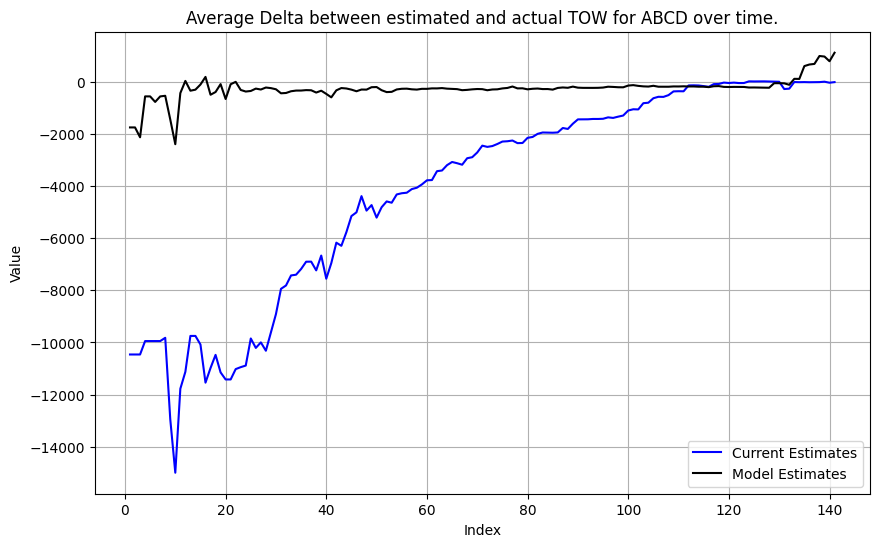

dict_keys(['Current Estimates', 'Model Estimates'])


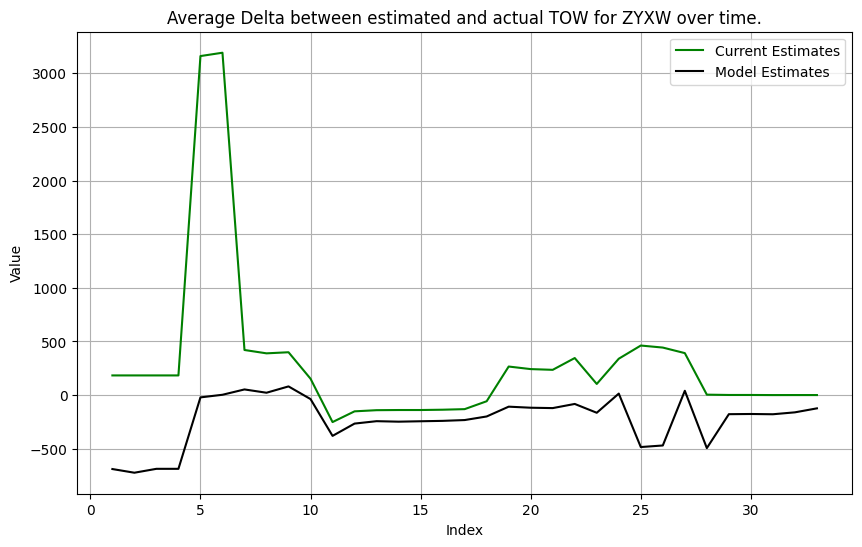

In [39]:
abcd_flights = test_df[test_df["airline_code"] == "AB"]["flight_id"].unique()
zyxw_flights = test_df[test_df["airline_code"] == "ZY"]["flight_id"].unique()

for airline_code, color, flights in [("abcd", "blue", abcd_flights), ("zyxw", "green", zyxw_flights)]:
    deltas_filtered = {k: v for k, v in deltas.items() if k in flights}
    
    longest_delta = max([len(v["current"]) for v in deltas_filtered.values()])

    average_delta_current = []
    average_delta_model = []
    for i in range(1, longest_delta + 1):
        timestep_current = [v["current"][-i] for v in deltas_filtered.values() if i < len(v["current"])]
        timestep_model = [v["model"][-i] for v in deltas_filtered.values() if i < len(v["model"])]
        # if len(timestep_current) >= 10:
        average_delta_current.insert(0, np.mean(timestep_current))
        average_delta_model.insert(0, np.mean(timestep_model))
    
    title = f"Average Delta between estimated and actual TOW for {airline_code.upper()} over time."
    plot_dict({
        "Current Estimates": average_delta_current,
        "Model Estimates": average_delta_model
        }, title, color)